In [14]:
import nltk
from nltk.tokenize import sent_tokenize

# Ensure tokenizer data are available
nltk.download("punkt")

# Load the text
with open("../cleaned_text/vol3_11_LIFE_OF_C_CAESAR.txt", "r", encoding="utf-8") as f:
    text = f.read()

# Split into sentences
sentences = sent_tokenize(text)
print(f"Total sentences: {len(sentences)}")
print(sentences[:5])  # preview

Total sentences: 572
['LIFE OF C. CAESAR.', 'I.', 'When Sulla got possession of the supreme power, he confiscated the marriage portion of Cornelia the daughter of Cinna who had once enjoyed the supremacy in Rome, because he could not either by promises or threats induce Caesar to part with her.', "The cause of the enmity between Caesar and Sulla was Caesar's relationship to Marius; for the elder Marius was the husband of Julia the sister of Caesar's father, and Julia was the mother of the younger Marius, who was consequently Caesar's cousin.", "Caesar was not content with being let alone by Sulla, who was at first fully occupied with the proscriptions and other matters, but he presented himself to the people as a candidate for a priesthood, though he had hardly arrived at man's estate."]


[nltk_data] Downloading package punkt to /Users/sjhuskey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
import re


def clean_sentence(s):
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[^A-Za-z ,;.'!?-]", "", s)
    return s.strip()


sentences = [clean_sentence(s) for s in sentences if s.strip()]

In [16]:
from transformers import pipeline

sentiment_analyzer = pipeline(
    "sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english"
)

results = sentiment_analyzer(sentences)

Device set to use mps:0


In [17]:
import pandas as pd

df = pd.DataFrame(
    {
        "sentence": sentences,
        "label": [r["label"] for r in results],
        "score": [r["score"] for r in results],
    }
)

In [18]:
df["label"].value_counts(normalize=True)

label
NEGATIVE    0.541958
POSITIVE    0.458042
Name: proportion, dtype: float64

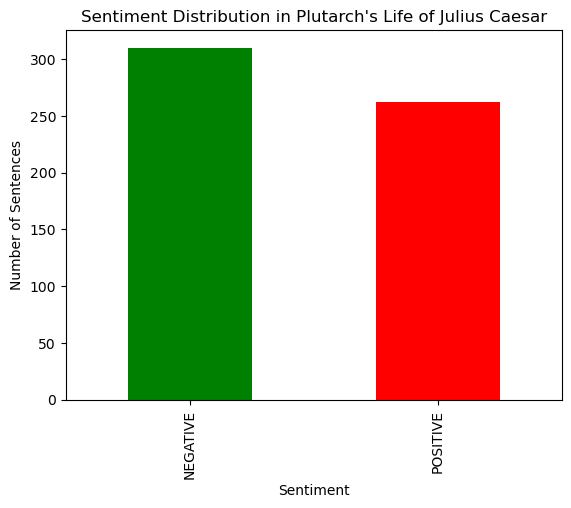

In [19]:
import matplotlib.pyplot as plt

df["label"].value_counts().plot(kind="bar", color=["green", "red", "gray"])
plt.title("Sentiment Distribution in Plutarch's Life of Julius Caesar")
plt.xlabel("Sentiment")
plt.ylabel("Number of Sentences")
plt.show()

In [20]:
top_pos = df[df["label"] == "POSITIVE"].nlargest(5, "score")
top_neg = df[df["label"] == "NEGATIVE"].nlargest(5, "score")

print("Most Positive Sentences:")
for s in top_pos["sentence"]:
    print("-", s, "\n")

print("\nMost Negative Sentences:")
for s in top_neg["sentence"]:
    print("-", s, "\n")

Most Positive Sentences:
- Crassinius stretching out his right hand and calling out aloud, said, We shall have a splendid victory, Caesar; and you shall praise me whether I survive the day or die. 

- At Rome Caesar got a brilliant popularity by aiding at trials with his eloquence; and he gained also much good will by his agreeable mode of saluting people and his pleasant manners, for he was more attentive to please than persons usually are at that age. 

- So great were the good-will and devotion of Caesar's soldiers to him, that those who under other generals were in no way superior to ordinary soldiers, were invincible and irresistible and ready to meet any danger for Caesar's glory. 

- The partizans of Brutus, just as they were, warm from the slaughter, and showing their bare swords, advanced all in a body from the Senate-house to the Capitol, not like men who were flying, but exultant and confident, calling the people to liberty and joined by the nobles who met them. 

- For the 

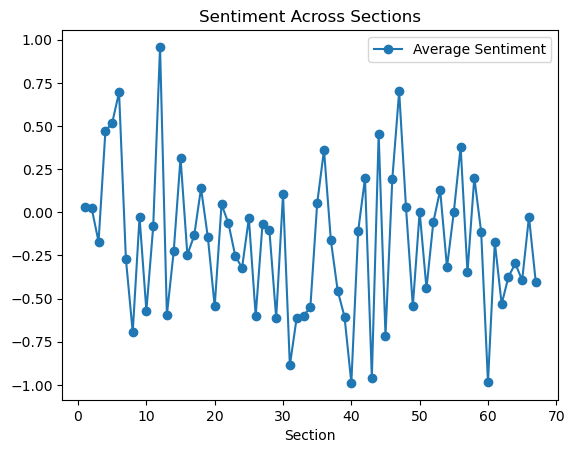

In [21]:
import re

sections = re.split(r"\n[A-Z]+\.", text)
section_sentiments = []
for i, sec in enumerate(sections[1:], 1):
    sents = sent_tokenize(sec)
    results = sentiment_analyzer(sents)
    avg_score = sum(
        r["score"] if r["label"] == "POSITIVE" else -r["score"] for r in results
    ) / len(results)
    section_sentiments.append({"Section": i, "Average Sentiment": avg_score})

pd.DataFrame(section_sentiments).plot(
    x="Section",
    y="Average Sentiment",
    kind="line",
    marker="o",
    title="Sentiment Across Sections",
)
plt.show()

In [22]:
import nltk, re, pandas as pd
from nltk.tokenize import sent_tokenize
from transformers import pipeline

nltk.download("punkt")

with open("../cleaned_text/vol3_11_LIFE_OF_C_CAESAR.txt", "r", encoding="utf-8") as f:
    text = f.read()

sentences = [re.sub(r"\s+", " ", s).strip() for s in sent_tokenize(text)]
sentiment_analyzer = pipeline(
    "sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english"
)
results = sentiment_analyzer(sentences)

df = pd.DataFrame(
    {
        "sentence": sentences,
        "label": [r["label"] for r in results],
        "score": [r["score"] for r in results],
    }
)

[nltk_data] Downloading package punkt to /Users/sjhuskey/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Device set to use mps:0


In [24]:
import spacy

nlp = spacy.load("en_core_web_sm")

entities_per_sentence = []

for sent in df["sentence"]:
    doc = nlp(sent)
    ents = [ent.text for ent in doc.ents if ent.label_ in ["PERSON", "GPE"]]
    entities_per_sentence.append(list(set(ents)))  # remove duplicates per sentence

df["entities"] = entities_per_sentence
df.head()

,sentence,label,score,entities
0,LIFE OF C. CAESAR.,POSITIVE,0.985623,[]
1,I.,POSITIVE,0.992082,[]
2,When Sulla got possession of the supreme power...,NEGATIVE,0.982908,"[Cornelia, Rome, Cinna, Sulla]"
3,The cause of the enmity between Caesar and Sul...,NEGATIVE,0.531475,"[Marius, Julia]"
4,Caesar was not content with being let alone by...,POSITIVE,0.982040,[Sulla]


In [25]:
import itertools
import networkx as nx

G = nx.Graph()

for _, row in df.iterrows():
    entities = row["entities"]
    if len(entities) > 1:
        sentiment_value = row["score"] if row["label"] == "POSITIVE" else -row["score"]
        for e1, e2 in itertools.combinations(entities, 2):
            if G.has_edge(e1, e2):
                G[e1][e2]["weight_sum"] += sentiment_value
                G[e1][e2]["count"] += 1
            else:
                G.add_edge(e1, e2, weight_sum=sentiment_value, count=1)

# compute average weight
for e1, e2, data in G.edges(data=True):
    data["avg_sentiment"] = data["weight_sum"] / data["count"]

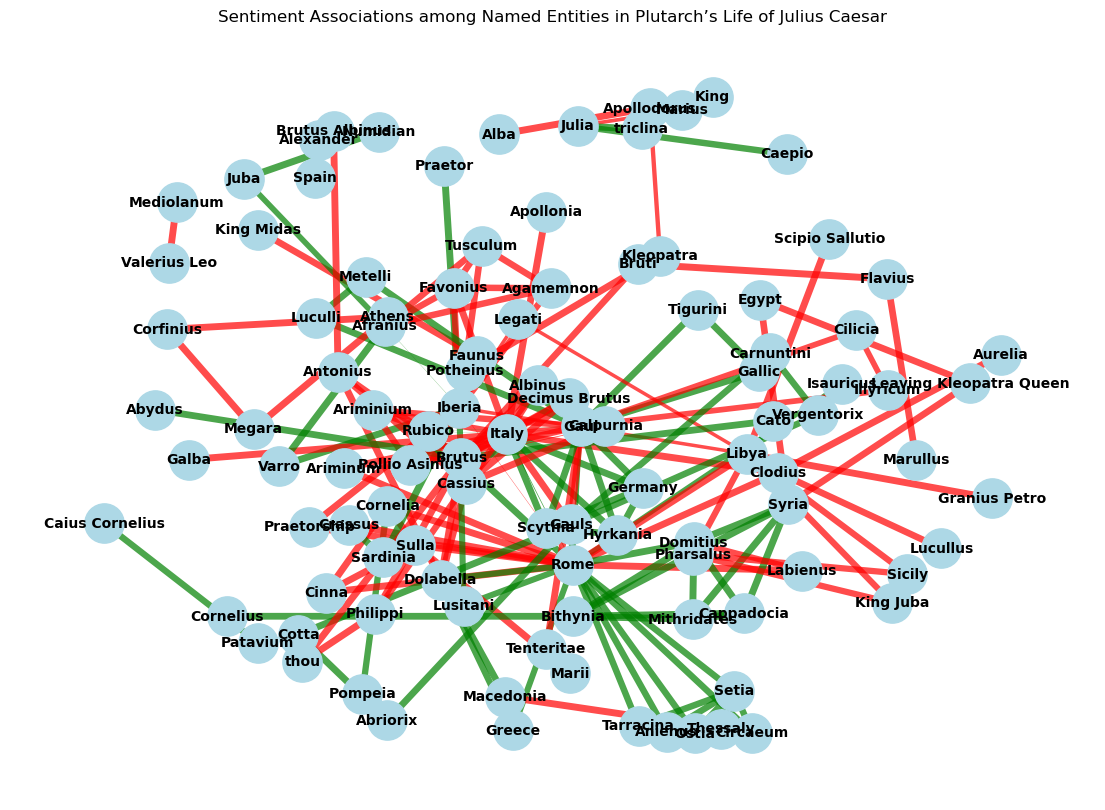

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 10))

pos = nx.spring_layout(G, k=0.5, seed=42)
edges = G.edges(data=True)
colors = ["green" if d["avg_sentiment"] > 0 else "red" for (_, _, d) in edges]
weights = [abs(d["avg_sentiment"]) * 5 for (_, _, d) in edges]

nx.draw_networkx_nodes(G, pos, node_color="lightblue", node_size=800)
nx.draw_networkx_edges(G, pos, edge_color=colors, width=weights, alpha=0.7)
nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

plt.title(
    "Sentiment Associations among Named Entities in Plutarch’s Life of Julius Caesar"
)
plt.axis("off")
plt.show()

In [27]:
import re


def contains_both(sentence, name1="Caesar", name2="Brutus"):
    s = sentence.lower()
    return bool(re.search(name1.lower(), s) and re.search(name2.lower(), s))


df_both = df[df["sentence"].apply(contains_both)]
print(f"Found {len(df_both)} sentences mentioning both Caesar and Brutus.")

Found 14 sentences mentioning both Caesar and Brutus.


In [30]:
pd.set_option("display.max_colwidth", None)
display(df_both[["sentence", "label", "score"]])

,sentence,label,score
380,"Of those who were taken prisoners, Caesar drafted most into his legions; and he pardoned many men of distinction, among whom was Brutus, who afterwards murdered him.",POSITIVE,0.990364
381,"Caesar is said to have been very much troubled at his not being found, but when Brutus, who had escaped unhurt, presented himself to Caesar, he was greatly pleased.",POSITIVE,0.999594
499,"The honours and favours which Brutus had received from Caesar dulled him towards attempting of his own proper motion the overthrow of the monarchical power; for not only was his life saved at the battle of Pharsalus after the rout of Pompeius, and many of his friends also at his entreaty, but besides this he had great credit with Caesar.",NEGATIVE,0.948753
501,"For it is said that Caesar observed that Cassius urged better grounds of preference, but that he could not pass over Brutus.",NEGATIVE,0.985095
504,"By which Cassius, perceiving that his ambition was somewhat stirred, urged him more than he had done before, and pricked him on; and Cassius himself had also a private grudge against Caesar for the reasons which I have mentioned in the Life of Brutus.",POSITIVE,0.988344
519,"In the mean time Decimus Brutus, surnamed Albinus, who was in such favour with Caesar that he was made in his will his second heir, but was engaged in the conspiracy with the other Brutus and Cassius, being afraid that if Caesar escaped that day, the affair might become known, ridiculed the seers and chided Caesar for giving cause for blame and censure to the Senate who would consider themselves insulted: he said, ""That the Senate had met at his bidding and that they were all ready to pass a decree, that he should be proclaimed King of the provinces out of Italy and should wear a diadem whenever he visited the rest of the earth and sea; but if any one shall tell them when they are taking their seats, to be gone now and to come again, when Calpurnia shall have had better dreams, what may we not expect to be said by those who envy you?",NEGATIVE,0.992471
521,"As he said this, Brutus took Caesar by the hand and began to lead him forth: and he had gone but a little way from the door, when a slave belonging to another person, who was eager to get at Caesar but was prevented by the press and numbers about him, rushing into the house delivered himself up to Calpurnia and told her to keep him till Caesar returned, for he had important things to communicate to him.",POSITIVE,0.785301
523,"Artemidorus, a Knidian by birth, and a professor of Greek philosophy, which had brought him into the familiarity of some of those who belonged to the party of Brutus, so that he knew the greater part of what was going on, came and brought in a small roll the information which he intended to communicate; but observing that Caesar gave each roll as he received it to the attendants about him, he came very near, and said, ""This you alone should read, Caesar, and read it soon; for it is about weighty matters which concern you.""",POSITIVE,0.994299
529,"Now Antonius, who was faithful to Caesar and a robust man, was kept on the outside by Brutus Albinus, who purposely engaged him in a long conversation.",NEGATIVE,0.990697
530,"When Caesar entered, the Senate rose to do him honour, and some of the party of Brutus stood around his chair at the back, and others presented themselves before him, as if their purpose was to support the prayer of Tillius Cimber on behalf of his exiled brother, and they all joined in entreaty, following Caesar as far as his seat.",POSITIVE,0.982974


In [29]:
df_both_sorted = df_both.sort_values(by="score", ascending=False)
display(df_both_sorted)

,sentence,label,score,entities
381,Caesar is said to have been very much troubled...,POSITIVE,0.999594,[Brutus]
563,"But chief of all, the phantom that appeared to...",NEGATIVE,0.999175,[Brutus]
542,"After Caesar was killed, though Brutus came fo...",NEGATIVE,0.998388,[Brutus]
523,"Artemidorus, a Knidian by birth, and a profess...",POSITIVE,0.994299,[Brutus]
519,"In the mean time Decimus Brutus, surnamed Albi...",NEGATIVE,0.992471,"[Albinus, Decimus Brutus, Calpurnia, Italy, Br..."
529,"Now Antonius, who was faithful to Caesar and a...",NEGATIVE,0.990697,"[Antonius, Brutus Albinus]"
380,"Of those who were taken prisoners, Caesar draf...",POSITIVE,0.990364,[Brutus]
504,"By which Cassius, perceiving that his ambition...",POSITIVE,0.988344,[]
548,On the next day Brutus came down and addressed...,POSITIVE,0.987864,[Brutus]
501,For it is said that Caesar observed that Cassi...,NEGATIVE,0.985095,[Brutus]
